In [1]:
from fastai.tabular import *
from fastai.metrics import *
from fastai.callbacks import CSVLogger
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
trn_df = pd.read_csv('train.csv',index_col='ID_code')
tst_df = pd.read_csv('test.csv',index_col='ID_code')

trn_df.reset_index(inplace=True)
trn_df.drop('ID_code',inplace=True,axis=1)

In [3]:
trn_1_rows = trn_df.loc[trn_df.target == 1].index
trn_0_rows = trn_df.loc[trn_df.target == 0].index
trn_rows = trn_1_rows[-15000:].append(trn_0_rows[:20000])
val_rows = trn_1_rows[:5098].append(trn_0_rows[-159902:])

In [4]:
procs = [Normalize]

trn_1 = trn_df.loc[trn_df.target == 1,:]
trn_0 = trn_df.where(trn_df.target == 0)[:len(trn_1)]
trn = trn_1.append(trn_0,ignore_index=True)

In [6]:
data = (TabularList.from_df(trn_df,procs=procs,cont_names=tst_df.columns)
        .split_by_idx(val_rows)
       .label_from_df('target')
       .add_test(TabularList.from_df(tst_df))
       .databunch(bs=64,num_workers=16))

In [8]:
_ = iter(data.train_dl)

In [29]:
next(_)

[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([[-0.3405, -0.2237, -1.6078,  ...,  1.7340,  0.3307,  0.6777],
          [-1.1951, -0.6017,  0.9285,  ...,  0.5099,  0.0564, -0.5901],
          [-1.5945,  0.6603, -0.8802,  ..., -0.2292, -1.4918, -1.9682],
          ...,
          [ 1.7917,  0.1094,  0.8412,  ..., -0.0877, -0.6943,  1.9838],
          [ 0.3161, -1.6773, -0.8943,  ...,  1.0366, -1.2438,  1.1472],
          [-0.4978, -0.3471, -1.1651,  ..., -0.0261, -0.8260, -0.5721]],
         device='cuda:0')],
 tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
         0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
         0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')]

In [12]:
def struct_res_block(nf,no, dense:bool=True, norm_type:Optional[NormType]=NormType.Batch, bottle:bool=True):
    "Resnet block of `nf` features fro structural data"
    #norm2 = norm_type
    #if not dense and (norm_type==NormType.Batch): norm2 = NormType.BatchZero
    nf_inner = nf//2 if bottle else nf
    return SequentialEx(nn.Linear(nf, nf_inner),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(nf_inner),
                        nn.Linear(nf_inner, nf),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(nf),
                        MergeLayer(dense),
                        nn.Linear(2*nf,no),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(no))

In [17]:
class struct_resnet(nn.Module):
    def __init__(self,lyrs):
        super().__init__()
        self.lyrs = [struct_res_block(lyrs[i],lyrs[i+1]) for i in range(0,len(lyrs)-1)]
        self.net = nn.Sequential(*self.lyrs)

    def forward(self,A,B):
        return self.net(B)

In [99]:
learn = Learner(data,struct_resnet([200,400,400,400,128,8,2]),loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

In [105]:
data

TabularDataBunch;

Train: LabelList (35000 items)
x: TabularList
var_0 -0.6169; var_1 -1.2950; var_2 0.3784; var_3 -0.8332; var_4 0.2236; var_5 -0.5587; var_6 -0.4002; var_7 0.6052; var_8 -1.5871; var_9 -1.3963; var_10 0.4660; var_11 1.0500; var_12 0.0224; var_13 -1.6167; var_14 0.5781; var_15 -0.0256; var_16 -1.4001; var_17 -0.2328; var_18 -1.4207; var_19 2.2699; var_20 -0.4469; var_21 -0.0591; var_22 -0.6554; var_23 -1.0018; var_24 0.9748; var_25 -0.8356; var_26 -0.2452; var_27 0.4765; var_28 -0.7336; var_29 0.3520; var_30 0.9256; var_31 1.1881; var_32 -1.3188; var_33 0.5222; var_34 -0.3787; var_35 1.2426; var_36 -0.4404; var_37 0.8896; var_38 -1.3997; var_39 0.7953; var_40 0.1179; var_41 -0.3293; var_42 0.5174; var_43 1.5374; var_44 0.4866; var_45 0.2916; var_46 -1.8950; var_47 -0.1760; var_48 0.0824; var_49 -1.4682; var_50 0.2708; var_51 1.8563; var_52 0.3352; var_53 -1.1211; var_54 -0.2091; var_55 0.3493; var_56 -1.4376; var_57 -1.1052; var_58 -0.2401; var_59 1.3934; var_60 0.9434

In [102]:
learn.data = data1

In [103]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [104]:
learn.data

TabularDataBunch;

Train: LabelList (140000 items)
x: TabularList
var_0 0.2700; var_1 -0.6220; var_2 1.1943; var_3 -0.6892; var_4 0.7923; var_5 1.5390; var_6 0.2470; var_7 -0.0040; var_8 0.8615; var_9 0.4163; var_10 -0.1462; var_11 1.8918; var_12 -0.0020; var_13 -0.0259; var_14 -0.9358; var_15 -2.1147; var_16 1.7578; var_17 -1.4737; var_18 -0.9473; var_19 2.0213; var_20 -1.6806; var_21 -1.7731; var_22 1.4912; var_23 0.6675; var_24 -0.9539; var_25 0.7818; var_26 -1.3015; var_27 -0.9331; var_28 -0.6211; var_29 -1.7215; var_30 -0.2022; var_31 -1.1658; var_32 0.6940; var_33 1.0642; var_34 -0.1168; var_35 -0.5997; var_36 0.1958; var_37 -0.0115; var_38 0.0427; var_39 0.7406; var_40 -0.5294; var_41 -1.2490; var_42 -1.9302; var_43 0.6901; var_44 -1.3051; var_45 -1.6234; var_46 -1.3851; var_47 1.1952; var_48 1.7314; var_49 1.1446; var_50 -1.3096; var_51 -0.0248; var_52 -0.3160; var_53 0.8881; var_54 -1.0957; var_55 1.0261; var_56 0.7603; var_57 0.9306; var_58 -0.2937; var_59 -0.0709; var_60 -0.

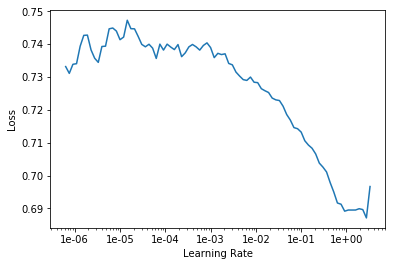

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(50,max_lr=.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.475776,4.129023,0.849600,00:19


In [72]:
!ls

exps			     nn_100ep.csv		      test.csv
exps.ipynb		     nn_2000ep.csv		      torch_NN.ipynb
fcn_cnn_exps.ipynb	     nn.py			      train.buffer
forrest_256.csv		     sample_submission.csv	      train.csv
forrest_32.csv		     siamese_network_prototype.ipynb  try1.csv
history_2.csv		     siam_nn.py			      try1.zip
history_new.csv		     siam_tabular.ipynb		      xgb_99999.csv
history_resnet_balanced.csv  sl_learn_ml.ipynb		      xgb_9999.csv
Linear.ipynb		     struct_renet.ipynb
models			     test.buffer


In [80]:
learn.model.load_state_dict(torch.load('models/second_iter_res'))

In [81]:
p = learn.get_preds(DatasetType.Valid)

In [82]:
pred = p[0]

In [83]:
preds = pred.cpu().numpy()

In [84]:
preds = preds.argmax(axis=1)

In [85]:
act = p[1].cpu().numpy()

In [86]:
len(preds),len(act)

(165000, 165000)

In [87]:
from sklearn.metrics import roc_auc_score

In [88]:
roc_auc_score(act,preds)

0.5

In [38]:
_1 = pd.read_csv('exps/history_stage1.csv',index_col='epoch')

In [30]:
_ = pd.read_csv('exps/history.csv',index_col='epoch')

In [31]:
_.head(2)

,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
epoch,,,,,,,
0,0.212568,0.205553,0.913667,0.684392,0.291178,0.408541,NaN
1,0.190916,0.207602,0.913367,0.748686,0.231771,0.353965,NaN


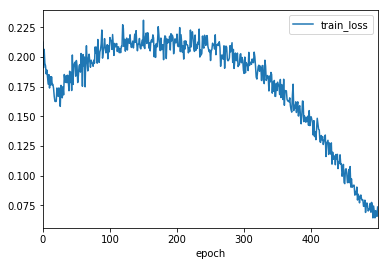

In [32]:
_.plot(y='train_loss')

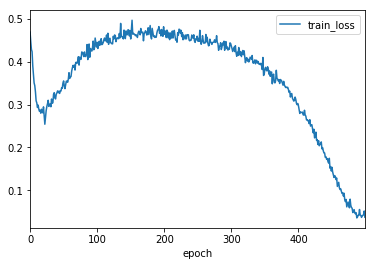

In [39]:
_1.plot(y='train_loss')

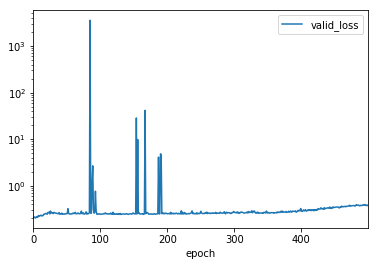

In [33]:
_.plot(y='valid_loss',logy=True)

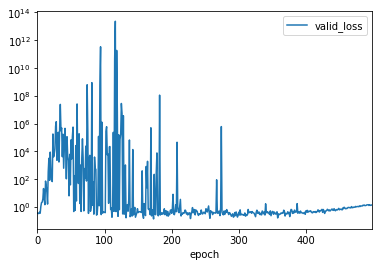

In [40]:
_1.plot(y='valid_loss',logy=True)

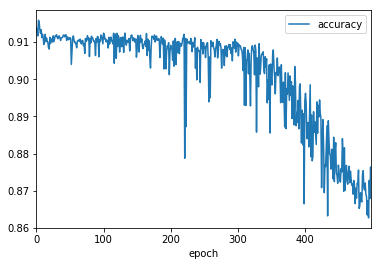

In [34]:
_.plot(y='accuracy')

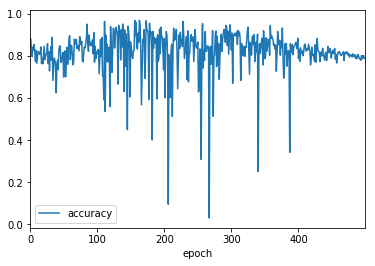

In [41]:
_1.plot(y='accuracy')

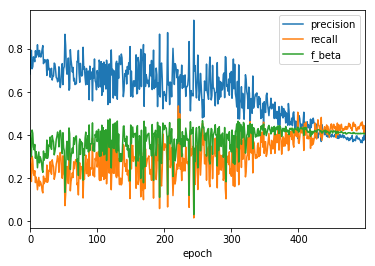

In [37]:
_.plot(y=['precision','recall','f_beta'])

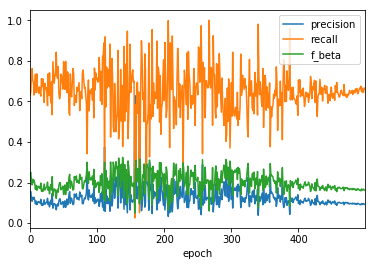

In [42]:
_1.plot(y=['precision','recall','f_beta'])

In [49]:
import torch

In [51]:
torch.save(learn.model.state_dict(),'models/balanced_resnet_500ep')

In [94]:
learn.model.load_state_dict(torch.load('./exps/models/small_Resnet_with_more_reg'))

RuntimeError: Error(s) in loading state_dict for struct_resnet:
	Missing key(s) in state_dict: "net.0.layers.7.weight", "net.0.layers.7.bias", "net.0.layers.9.weight", "net.0.layers.9.bias", "net.0.layers.9.running_mean", "net.0.layers.9.running_var", "net.1.layers.7.weight", "net.1.layers.7.bias", "net.1.layers.9.weight", "net.1.layers.9.bias", "net.1.layers.9.running_mean", "net.1.layers.9.running_var", "net.2.layers.7.weight", "net.2.layers.7.bias", "net.2.layers.9.weight", "net.2.layers.9.bias", "net.2.layers.9.running_mean", "net.2.layers.9.running_var", "net.3.layers.7.weight", "net.3.layers.7.bias", "net.3.layers.9.weight", "net.3.layers.9.bias", "net.3.layers.9.running_mean", "net.3.layers.9.running_var", "net.4.layers.0.weight", "net.4.layers.0.bias", "net.4.layers.2.weight", "net.4.layers.2.bias", "net.4.layers.2.running_mean", "net.4.layers.2.running_var", "net.4.layers.3.weight", "net.4.layers.3.bias", "net.4.layers.5.weight", "net.4.layers.5.bias", "net.4.layers.5.running_mean", "net.4.layers.5.running_var", "net.4.layers.7.weight", "net.4.layers.7.bias", "net.4.layers.9.weight", "net.4.layers.9.bias", "net.4.layers.9.running_mean", "net.4.layers.9.running_var", "net.5.layers.0.weight", "net.5.layers.0.bias", "net.5.layers.2.weight", "net.5.layers.2.bias", "net.5.layers.2.running_mean", "net.5.layers.2.running_var", "net.5.layers.3.weight", "net.5.layers.3.bias", "net.5.layers.5.weight", "net.5.layers.5.bias", "net.5.layers.5.running_mean", "net.5.layers.5.running_var", "net.5.layers.7.weight", "net.5.layers.7.bias", "net.5.layers.9.weight", "net.5.layers.9.bias", "net.5.layers.9.running_mean", "net.5.layers.9.running_var". 
	Unexpected key(s) in state_dict: "net.0.layers.10.weight", "net.0.layers.10.bias", "net.0.layers.10.running_mean", "net.0.layers.10.running_var", "net.0.layers.10.num_batches_tracked", "net.0.layers.8.weight", "net.0.layers.8.bias", "net.1.layers.10.weight", "net.1.layers.10.bias", "net.1.layers.10.running_mean", "net.1.layers.10.running_var", "net.1.layers.10.num_batches_tracked", "net.1.layers.8.weight", "net.1.layers.8.bias", "net.2.layers.10.weight", "net.2.layers.10.bias", "net.2.layers.10.running_mean", "net.2.layers.10.running_var", "net.2.layers.10.num_batches_tracked", "net.2.layers.8.weight", "net.2.layers.8.bias", "net.3.layers.10.weight", "net.3.layers.10.bias", "net.3.layers.10.running_mean", "net.3.layers.10.running_var", "net.3.layers.10.num_batches_tracked", "net.3.layers.8.weight", "net.3.layers.8.bias". 
	size mismatch for net.1.layers.0.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for net.1.layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.1.layers.2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.1.layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.1.layers.2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.1.layers.2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.1.layers.3.weight: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([400, 200]).
	size mismatch for net.1.layers.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.1.layers.5.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.1.layers.5.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.1.layers.5.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.1.layers.5.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.2.layers.0.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for net.2.layers.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.2.layers.2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.2.layers.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.2.layers.2.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.2.layers.2.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.2.layers.3.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([400, 200]).
	size mismatch for net.2.layers.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.2.layers.5.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.2.layers.5.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.2.layers.5.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.2.layers.5.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.3.layers.0.weight: copying a param with shape torch.Size([4, 8]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for net.3.layers.0.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.3.layers.2.weight: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.3.layers.2.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.3.layers.2.running_mean: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.3.layers.2.running_var: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for net.3.layers.3.weight: copying a param with shape torch.Size([8, 4]) from checkpoint, the shape in current model is torch.Size([400, 200]).
	size mismatch for net.3.layers.3.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.3.layers.5.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.3.layers.5.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.3.layers.5.running_mean: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for net.3.layers.5.running_var: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([400]).

In [101]:
data1 = (TabularList.from_df(trn_df,procs=procs,cont_names=tst_df.columns)
        .split_by_rand_pct(0.3,seed=42)
       .label_from_df('target')
       .add_test(TabularList.from_df(tst_df))
       .databunch(bs=64,num_workers=16))

In [76]:
learn = Learner(data1,struct_resnet([200,400,400,400,128,8,2]),loss_func=nn.CrossEntropyLoss(),metrics=accuracy,callback_fns=[CSVLogger])

In [77]:
learn.load('../exps/models/res_1000ep_full_data')

Learner(data=TabularDataBunch;

Train: LabelList (140000 items)
x: TabularList
var_0 0.2700; var_1 -0.6220; var_2 1.1943; var_3 -0.6892; var_4 0.7923; var_5 1.5390; var_6 0.2470; var_7 -0.0040; var_8 0.8615; var_9 0.4163; var_10 -0.1462; var_11 1.8918; var_12 -0.0020; var_13 -0.0259; var_14 -0.9358; var_15 -2.1147; var_16 1.7578; var_17 -1.4737; var_18 -0.9473; var_19 2.0213; var_20 -1.6806; var_21 -1.7731; var_22 1.4912; var_23 0.6675; var_24 -0.9539; var_25 0.7818; var_26 -1.3015; var_27 -0.9331; var_28 -0.6211; var_29 -1.7215; var_30 -0.2022; var_31 -1.1658; var_32 0.6940; var_33 1.0642; var_34 -0.1168; var_35 -0.5997; var_36 0.1958; var_37 -0.0115; var_38 0.0427; var_39 0.7406; var_40 -0.5294; var_41 -1.2490; var_42 -1.9302; var_43 0.6901; var_44 -1.3051; var_45 -1.6234; var_46 -1.3851; var_47 1.1952; var_48 1.7314; var_49 1.1446; var_50 -1.3096; var_51 -0.0248; var_52 -0.3160; var_53 0.8881; var_54 -1.0957; var_55 1.0261; var_56 0.7603; var_57 0.9306; var_58 -0.2937; var_59 -0.070

In [78]:
torch.save(learn.model.state_dict(),'models/second_iter_res')

In [63]:
learn.model.load_state_dict(torch.load('models/balanced_resnet_500ep'))

In [68]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


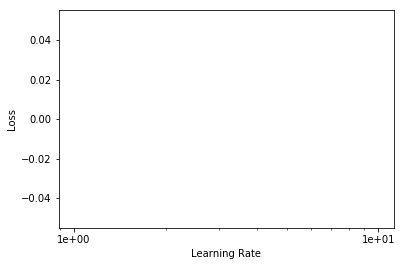

In [69]:
learn.recorder.plot()

In [96]:
learn.data

TabularDataBunch;

Train: LabelList (35000 items)
x: TabularList
var_0 -0.6169; var_1 -1.2950; var_2 0.3784; var_3 -0.8332; var_4 0.2236; var_5 -0.5587; var_6 -0.4002; var_7 0.6052; var_8 -1.5871; var_9 -1.3963; var_10 0.4660; var_11 1.0500; var_12 0.0224; var_13 -1.6167; var_14 0.5781; var_15 -0.0256; var_16 -1.4001; var_17 -0.2328; var_18 -1.4207; var_19 2.2699; var_20 -0.4469; var_21 -0.0591; var_22 -0.6554; var_23 -1.0018; var_24 0.9748; var_25 -0.8356; var_26 -0.2452; var_27 0.4765; var_28 -0.7336; var_29 0.3520; var_30 0.9256; var_31 1.1881; var_32 -1.3188; var_33 0.5222; var_34 -0.3787; var_35 1.2426; var_36 -0.4404; var_37 0.8896; var_38 -1.3997; var_39 0.7953; var_40 0.1179; var_41 -0.3293; var_42 0.5174; var_43 1.5374; var_44 0.4866; var_45 0.2916; var_46 -1.8950; var_47 -0.1760; var_48 0.0824; var_49 -1.4682; var_50 0.2708; var_51 1.8563; var_52 0.3352; var_53 -1.1211; var_54 -0.2091; var_55 0.3493; var_56 -1.4376; var_57 -1.1052; var_58 -0.2401; var_59 1.3934; var_60 0.9434

In [43]:
_ = pd.read_csv('exps/history.csv',index_col='epoch')

In [44]:
_.head(2)

,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
epoch,,,,,,,
0,0.465891,0.337339,0.889376,0.161738,0.616909,0.256285,NaN
1,0.448041,0.422826,0.758370,0.095149,0.801491,0.170105,NaN


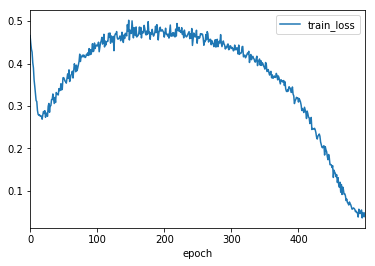

In [45]:
_.plot(y='train_loss')

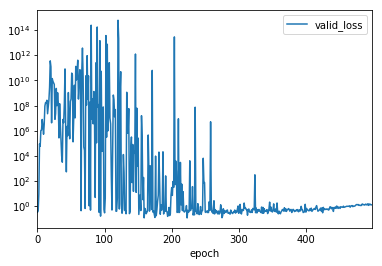

In [46]:
_.plot(y='valid_loss',logy=True)

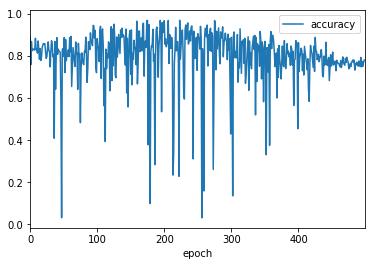

In [47]:
_.plot(y='accuracy')

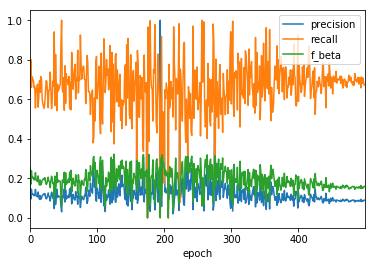

In [48]:
_.plot(y=['precision','recall','f_beta'])